In [7]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from scipy.stats import norm
from collections import Counter
import matplotlib.pyplot as plt

### Calculate # Named Storms in Atlantic Hurricane Season
real_time_NS = 5

#### specify end of real time NS (UTC) (time of record for how many named storms there currently are)
NS_time_end_str = "2024-09-07 00:00:00"
NS_time = datetime.fromisoformat(NS_time_end_str)

last_valid_time = NS_time

#min_year = 1851
min_year = 1966

# Note: this auto-tunes an expotential decay parameter for expected NS using MSE.
# Make sure to:
#   1) Check the difference of MSE in the validation
#   2) Check to make sure that the "Rate final tuning" is within the bounds of the rates tried

# Update: Oct 22: Since the last few days the exponential decay validates poorly and is no longer robust
#   Will use second predictor even though it has only 16 samples

In [8]:
##### CONFIG BASIN AND INTENSITY MODEL
match_basin = 'AL'

In [9]:
ab_column_names = [
    'BASIN',
    'CY',
    'YYYYMMDDHH',
    'TECHNUM/MIN',
    'TECH',
    'TAU',
    'LatN/S',
    'LonE/W',
    'VMAX',
    'MSLP',
    'TY',
    'RAD',
    'WINDCODE',
    'RAD1',
    'RAD2',
    'RAD3',
    'RAD4',
    'POUTER',
    'ROUTER',
    'RMW',
    'GUSTS',
    'EYE',
    'SUBREGION',
    'MAXSEAS',
    'INITIALS',
    'DIR',
    'SPEED',
    'STORMNAME',
    'DEPTH',
    'SEAS',
    'SEASCODE',
    'SEAS1',
    'SEAS2',
    'SEAS3',
    'SEAS4',
    'USERDEFINED1',
    'userdata1',
    'USERDEFINED2',
    'userdata2',
    'USERDEFINED3',
    'userdata3',
    'USERDEFINED4',
    'userdata4',
    'USERDEFINED5',
    'userdata5'
]

In [10]:
# exclude storms less than 35 kt
# exclude forecasts at 00h (since this may already be included in real time NS)
NS_min_kt = 35
storm_intensities_above_min = {}

In [11]:
forecasts_NS = {}

In [12]:
forecast_total_NS = 0
total_NS_until_forecast = real_time_NS + forecast_total_NS
print("")
print("Real-time NS:", real_time_NS)
print(f"Total NS (real-time + forecast) up until {last_valid_time}: {total_NS_until_forecast:.2f}")


Real-time NS: 5
Total NS (real-time + forecast) up until 2024-09-07 00:00:00: 5.00


In [13]:
print(storm_intensities_above_min)

{}


In [15]:

# Define a function to convert the components into datetime objects
def convert_to_datetime(components, debug = False):
    # only use first time
    try:
        c = "".join(components.astype(str))
        year = int(c[0:4])
        month = int(c[5:7])
        day = int(c[8:10])
        hour = int(c[11:13])
        minute = int(c[14:16])
        second = int(c[17:])
        dt = datetime(year, month, day, hour, minute, second)
        return dt
    except:
        if debug:
            print("err")
            print(components)
        return None
    
def extract_first_num(components):
    try:
        return components[0].astype(int)
    except:
        return None

def extract_first_str(components):
    try:
        return "".join(components[0].astype(str))
    except:
        return None

def extract_first_byte(components):
    try:
        return "".join(components[0].astype(str))
    except:
        return None

In [16]:
# Calculate historical NS energies from best tracks and use this to calculate expected NS values from the above values

# from https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/csv/
best_tracks_csv = 'ibtracs.NA.list.v04r00.csv'

# Read the CSV file into a DataFrame without automatically assigning column names
df = pd.read_csv(best_tracks_csv, header=0, skiprows=[1], low_memory=False)


In [17]:
# Create a dictionary that specifies the data types for each column
dtype_mapping = {
    'LAT': float,
    'LON': float,
    'WMO_WIND': float,
    'WMO_PRES': float,
    'USA_WIND': float,
    'DIST2LAND': float,
    'LANDFALL': float,
    'STORM_SPEED': float,
    'STORM_DIR': float
}

# Apply dtype conversion to specific columns, treating non-numeric values as NaN
for column, data_type in dtype_mapping.items():
    df[column] = pd.to_numeric(df[column], errors='coerce').astype(data_type)

# convert time to datetime
df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])


In [74]:
pd.set_option('display.max_rows', 10)
# Create a mask to filter the rows for only 6 hour times
# Also only include years from min_year
mask = (df['ISO_TIME'].dt.year >= min_year) & (df['ISO_TIME'].dt.hour.isin([0, 6, 12, 18])) & (df['ISO_TIME'].dt.minute == 0) & (df['ISO_TIME'].dt.second == 0)

# Apply the mask to filter the DataFrame
filtered_df = df[mask].copy()

# drop all but relevant column's for speed
selected_columns = ['SEASON', 'ISO_TIME', 'WMO_WIND', 'USA_WIND', 'NATURE', 'NAME', 'USA_STATUS', 'BASIN', 'USA_ATCF_ID']
filtered_df = filtered_df[selected_columns]

In [75]:
# exclude storms that cross basins by only including null basins (AL basin is a string 'NA' converted to NaN)
df_min_35kt = filtered_df.loc[(filtered_df['USA_WIND'] >= 35) & (filtered_df['USA_STATUS'].isin(['TS', 'SS', 'HU', 'HR'])) & (filtered_df['BASIN'].isnull())]
# filter out storms out of season
#df_min_35kt = df_min_35kt[(df_min_35kt['ISO_TIME'].dt.month >= 6) & (df_min_35kt['ISO_TIME'].dt.month <= 11)]
df_min_35kt.reset_index()

,index,SEASON,ISO_TIME,WMO_WIND,USA_WIND,NATURE,NAME,USA_STATUS,BASIN,USA_ATCF_ID
0,73915,1966,1966-06-06 00:00:00,35.0,35.0,TS,ALMA,TS,NaN,AL011966
1,73917,1966,1966-06-06 06:00:00,40.0,40.0,TS,ALMA,TS,NaN,AL011966
2,73919,1966,1966-06-06 12:00:00,50.0,50.0,TS,ALMA,TS,NaN,AL011966
3,73921,1966,1966-06-06 18:00:00,65.0,65.0,TS,ALMA,HU,NaN,AL011966
4,73923,1966,1966-06-07 00:00:00,65.0,65.0,TS,ALMA,HU,NaN,AL011966
...,...,...,...,...,...,...,...,...,...,...
14207,126916,2023,2023-10-27 18:00:00,NaN,55.0,TS,TAMMY,TS,NaN,AL202023
14208,126918,2023,2023-10-28 00:00:00,NaN,50.0,TS,TAMMY,TS,NaN,AL202023
14209,126920,2023,2023-10-28 06:00:00,NaN,45.0,TS,TAMMY,TS,NaN,AL202023
14210,126922,2023,2023-10-28 12:00:00,NaN,45.0,TS,TAMMY,TS,NaN,AL202023


In [76]:
len(df.loc[(df['BASIN'].isnull())])

126392

In [77]:
df['BASIN']

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
126965    NaN
126966    NaN
126967    NaN
126968    NaN
126969    NaN
Name: BASIN, Length: 126970, dtype: object

In [140]:
# Calculate NS for up to NS_time_end_str for all years

NS_time_month = NS_time.month
NS_time_day = NS_time.day

season_NS = {}
season_kt = {}
kt_at_time = {}
season_NS_to_time_end = {}
season_NS_above_real_time = {}

for idx in range(0, len(df_min_35kt)):
    r = df_min_35kt.iloc[idx]
    t = r['ISO_TIME']
    #w = r['WMO_WIND']
    w = r['USA_WIND']
    kt_at_time[t] = w

years = list(set(list(df_min_35kt['SEASON'].values)))

NS_by_atcf_id = {}

for season in years:
    df_season_min_35kt = df_min_35kt.loc[(df_min_35kt['SEASON'] == season)].copy(deep=True)

    df_season_min_35kt = df_season_min_35kt.drop_duplicates(subset=['USA_ATCF_ID'])
    season_atcf_ids = sorted(list(set(df_season_min_35kt['USA_ATCF_ID'].values)))
    for atcf_id in season_atcf_ids:
        NS_by_atcf_id[atcf_id] = 1

    NS = len(season_atcf_ids)
    season_NS[season] = NS
    
    # exclude NS that are not representative for population statistics when they are below real time NS
    if NS >= real_time_NS:
        season_NS_above_real_time[season] = NS
    
    # calculate NS until NS_time_end_str for each year
    df_season_to_time_end_min_35kt = df_season_min_35kt.loc[
        (df_season_min_35kt['ISO_TIME'].dt.month < NS_time_month) | 
        (
            (df_season_min_35kt['ISO_TIME'].dt.month == NS_time_month) &
            (df_season_min_35kt['ISO_TIME'].dt.day <= NS_time_day)
        )
    ]
    
    remainder_season_atcf_ids = sorted(list(set(df_season_min_35kt['USA_ATCF_ID'].values)))
    remainder_NS = len(remainder_season_atcf_ids)
    season_NS_to_time_end[season] = remainder_NS

print(f"Done calculating NS for each year up until {NS_time.month}/{NS_time.day}")

Done calculating NS for each year up until 9/7


In [142]:
# use this to normalize a 1-d array
def normalize(matrix):
    norm = np.linalg.norm(matrix, 1)
    matrix = matrix/norm 
    return matrix

# use exponential decay (the difference passed should always be positive)
def custom_kernel(difference, rate):
    #return (1.0 / difference)
    return np.exp(-rate * difference)

def get_min_pair_by_value(d):
    # Find the key/value pair with the minimum value from a dict
    return min(d.items(), key=lambda x: x[1])

def mean_squared_error(predictions, actual_values):
    # Ensure both dictionaries have the same keys
    common_keys = set(predictions.keys()) & set(actual_values.keys())
    
    # Calculate the squared differences and sum them
    squared_diff_sum = sum((predictions[key] - actual_values[key])**2 for key in common_keys)
    
    # Calculate the mean squared error
    mse = squared_diff_sum / len(common_keys)
    
    return mse

In [222]:
### This should be done regularly (after every day?) to get lower variance and proper decay values considering the time until to the end of the season

### TUNING & VALIDATION for decay rates and expected NS (for this far out in year) ###

### do tuning on a partial dataset to calculate MSE and then do validation on the remaining dataset
### to make sure MSE is not too far off (this will be an estimate of the additional error/uncertainty in the tuning)

years = list(season_NS_to_time_end.keys())
years_above_real_time_NS = sorted(list(season_NS_above_real_time.keys()))

# Calculate the size of the first list (80%)
tuning_list_size = int(len(years) * 0.8)

# Randomly shuffle the original list
random.shuffle(years)

# Split the list into two new lists
years_tuning = years[:tuning_list_size]
years_validation = years[tuning_list_size:]
print(f"Tuning years: ", years_tuning)
print(f"Validation years: ", years_validation)

Tuning years:  [1986, 2001, 1978, 1998, 2004, 1992, 2017, 1968, 1979, 1989, 2016, 1982, 2008, 1991, 2010, 1995, 1980, 1967, 1969, 1970, 1987, 1971, 2013, 1999, 1990, 2006, 2003, 2011, 2019, 1994, 2007, 1984, 2018, 2023, 2022, 2000, 1993, 2005, 2009, 1976, 2020, 2014, 1988, 1996, 1981, 1977]
Validation years:  [1972, 1997, 1973, 2002, 2015, 2012, 1975, 1966, 1985, 1974, 2021, 1983]


In [236]:
min_rate = 0.01
max_rate = 0.1

# exponential decay weights
#rates_to_try = list(np.round(np.arange(0.1, 0.5, 0.001),3))
#rates_to_try = [0.0001, 0.001, 0.01, 0.1, 1]
rates_to_try = list(np.round(np.arange(min_rate, max_rate, 0.001),3))
mse_by_rate = {}

# Calculate weights for each decay rate
for rate in rates_to_try:
    expected_NS_by_tuning_year = {}
    # tune over only years for validation set
    for tuning_year in years_tuning:
        # for tuning this is the season_NS_to_time_end[tuning_year]
        tuning_NS = season_NS_to_time_end[tuning_year]

        tuning_diff_season_NS_to_time_end = {}

        for [year, NS] in season_NS_to_time_end.items():
            if year in years_tuning and year != tuning_year:
                tuning_diff_season_NS_to_time_end[year] = tuning_NS - NS

        # Calculate weights for each year
        weights_normalized = []
        weights = []
        for [year, diff] in tuning_diff_season_NS_to_time_end.items():        
            # Calculate weights using the custom kernel function
            weight = custom_kernel(np.abs(diff), rate)
            weights.append(weight)

        # Calculate the normalized weights
        weights_normalized = normalize(weights)

        # Calculate expected NS using normalized weights
        expected_NS = 0.0
        for [x, year] in list(enumerate(tuning_diff_season_NS_to_time_end)):
            expected_NS += (weights_normalized[x] * season_NS[year])
        #print(tuning_diff_season_NS_to_time_end)

        expected_NS_by_tuning_year[tuning_year] = expected_NS
    
    # calculate the MSE for this rate
    #print(expected_NS_by_tuning_year)
    mse = mean_squared_error(expected_NS_by_tuning_year, season_NS)
    mse_by_rate[rate] = mse

In [237]:
tuning_min_pair = get_min_pair_by_value(mse_by_rate)
print(f"(Validation) Rate , MSE (minimum) for tuning dataset: {tuning_min_pair}")

(Validation) Rate , MSE (minimum) for tuning dataset: (0.1, 16.756101109550514)


In [238]:
# TUNING above has minimum MSE for:
# Rate: 0.14, MSE: 578.8630529802942

In [239]:
## VALIDATION
# exponential decay weights
rates_to_try = list(np.round(np.arange(min_rate, max_rate, 0.001),3))
#rates_to_try = [0.0001, 0.001, 0.01, 0.1, 1]
mse_by_rate = {}

# Calculate weights for each decay rate
for rate in rates_to_try:
    expected_NS_by_validation_year = {}
    for validation_year in years_validation:
        # for validation this is the season_NS_to_time_end[validation_year]
        validation_NS = season_NS_to_time_end[validation_year]

        validation_diff_season_NS_to_time_end = {}

        for [year, NS] in season_NS_to_time_end.items():
            if year in years_validation and year != validation_year:
                validation_diff_season_NS_to_time_end[year] = validation_NS - NS

        # Calculate weights for each year
        weights_normalized = []
        weights = []
        for [year, diff] in validation_diff_season_NS_to_time_end.items():        
            # Calculate weights using the custom kernel function
            weight = custom_kernel(np.abs(diff), rate)
            weights.append(weight)

        # Calculate the normalized weights
        weights_normalized = normalize(weights)
        if rate == 1.184:
            print(weights_normalized)
        # Calculate expected NS using normalized weights
        expected_NS = 0.0
        for [x, year] in list(enumerate(validation_diff_season_NS_to_time_end)):
            expected_NS += (weights_normalized[x] * season_NS[year])

        expected_NS_by_validation_year[validation_year] = expected_NS
    
    # calculate the MSE for this rate
    #print(expected_NS_by_validation_year)
    mse = mean_squared_error(expected_NS_by_validation_year, season_NS)
    mse_by_rate[rate] = mse
    

In [240]:
validation_min_pair = get_min_pair_by_value(mse_by_rate)
print(f"(Validation) Rate : MSE (minimum) for validation dataset: {validation_min_pair}")

(Validation) Rate : MSE (minimum) for validation dataset: (0.1, 16.99266082074492)


In [241]:
# for validation, the minimum MSE:
# Rate: 0.102, MSE: 439.9012525009955
# from the validation-tuning set above, the tuning Rate: 0.14, MSE: 450.0207460685012

rmse_tuning = pow(tuning_min_pair[1], 0.5)
rmse_validation = pow(validation_min_pair[1], 0.5)
diff_rmse = abs(rmse_tuning - rmse_validation)
print(f"RMSE tuning: {rmse_tuning:.2f}")
print(f"RMSE validation: {rmse_validation:.2f}")
print(f"Difference of RMSE(tuning) - RMSE(validation): {diff_rmse:.2f}")

RMSE tuning: 4.09
RMSE validation: 4.12
Difference of RMSE(tuning) - RMSE(validation): 0.03


In [242]:
# FINAL TUNING

# exponential decay weights
rates_to_try = list(np.round(np.arange(min_rate, max_rate, 0.001),3))
#rates_to_try = [0.0001, 0.001, 0.01, 0.1, 1]
mse_by_rate = {}

# Calculate weights for each decay rate
for rate in rates_to_try:
    expected_NS_by_tuning_year = {}
    # tune over all years
    for tuning_year in years:
        # for tuning this is the season_NS_to_time_end[tuning_year]
        tuning_NS = season_NS_to_time_end[tuning_year]

        tuning_diff_season_NS_to_time_end = {}

        for [year, NS] in season_NS_to_time_end.items():
            if year in years and year != tuning_year:
                tuning_diff_season_NS_to_time_end[year] = tuning_NS - NS

        # Calculate weights for each year
        weights_normalized = []
        weights = []
        for [year, diff] in tuning_diff_season_NS_to_time_end.items():        
            # Calculate weights using the custom kernel function
            weight = custom_kernel(np.abs(diff), rate)
            weights.append(weight)

        # Calculate the normalized weights
        weights_normalized = normalize(weights)

        # Calculate expected NS using normalized weights
        expected_NS = 0.0
        for [x, year] in list(enumerate(tuning_diff_season_NS_to_time_end)):
            expected_NS += (weights_normalized[x] * season_NS[year])
        #print(tuning_diff_season_NS_to_time_end)

        expected_NS_by_tuning_year[tuning_year] = expected_NS
    
    # calculate the MSE for this rate
    #print(expected_NS_by_tuning_year)
    mse = mean_squared_error(expected_NS_by_tuning_year, season_NS)
    mse_by_rate[rate] = mse
    #print(f"Rate: {rate}, MSE: {mse}")

final_tuning_min_pair = get_min_pair_by_value(mse_by_rate)
print(f"(Tuning Final) Rate : MSE (minimum) for all past years: {final_tuning_min_pair}")

(Tuning Final) Rate : MSE (minimum) for all past years: (0.1, 16.16792831410667)


In [243]:
# minimum is Rate: 0.147, MSE: 518.519969751831
mse_final_tuning = final_tuning_min_pair[1]
rate_final_tuning = final_tuning_min_pair[0]
print(f"Rate final tuning: {rate_final_tuning:0.4f}")
print(f"MSE final tuning: {mse_final_tuning:.2f}")
rmse_final_tuning = pow(mse_final_tuning,0.5)
print("")
print(f"RMSE final tuning: {rmse_final_tuning:.2f}")

Rate final tuning: 0.1000
MSE final tuning: 16.17

RMSE final tuning: 4.02


In [152]:
def calculate_expected_NS(this_season_end = season_NS_to_time_end, repeat_counts = None):
    diff_season_NS_to_time_end = {}

    for [year, NS] in this_season_end.items():
        diff_season_NS_to_time_end[year] = present_NS - NS

    # exponential decay weights
    #rates_to_try = list(np.round(np.arange(0.080, 0.205, 0.005),3))
    rates_to_try = [rate_final_tuning]

    expected_NS_by_rate = {}
    weights_normalized_by_year = {}
    # Calculate weights for each decay rate
    for rate in rates_to_try:
        # Calculate weights for each year
        weights_normalized = []
        weights = []
        for [year, diff] in diff_season_NS_to_time_end.items():        
            # Calculate weights using the custom kernel function
            weight = custom_kernel(np.abs(diff), rate)
            weights.append(weight)

        # Calculate the normalized weights
        weights_normalized = normalize(weights)

        # store weights by year for useful statistics
        weights_normalized_by_year = {}

        weights_total = 0.0
        # Calculate expected NS using normalized weights
        expected_NS = 0.0
        for [x, year] in list(enumerate(diff_season_NS_to_time_end)):
            weights_normalized_by_year[year] = weights_normalized[x]
            if repeat_counts:
                repeat_count = repeat_counts[year]
                # can't just multiply by repeat_count without renormalizing
                expected_NS += (repeat_count * (weights_normalized[x] * season_NS[year]))
                weights_total += repeat_count * weights_normalized[x]
            else:
                expected_NS += (weights_normalized[x] * season_NS[year])
                weights_total += weights_normalized[x]

        # renormalize (only affected if repeat_counts is set)
        if weights_total == 0:
            expected_NS_by_rate[rate] = 0
        else:
            expected_NS_by_rate[rate] = expected_NS / weights_total

    expected_NS = expected_NS_by_rate[rate_final_tuning]

    return [expected_NS, weights_normalized_by_year]


Valid until: 2024-09-07 00:00:00
NS, Real-time + storm model forecast: 5.0
Tuned decay rate: 0.1

Expected NS (weight historical NS using exponential decay): 10.86


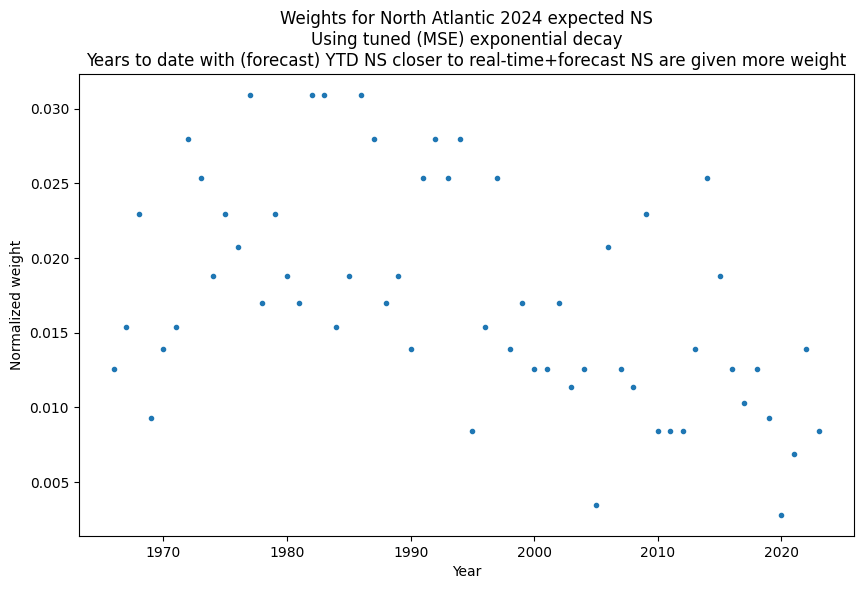

Top 10 weights (sorted by weight)
----------------------------------------
Rank  |  Year  |  Weight  |  Season NS
----------------------------------------
   1  |  1977  |  0.031   |  6.00
   2  |  1982  |  0.031   |  6.00
   3  |  1983  |  0.031   |  4.00
   4  |  1986  |  0.031   |  6.00
   5  |  1972  |  0.028   |  7.00
   6  |  1987  |  0.028   |  7.00
   7  |  1992  |  0.028   |  7.00
   8  |  1994  |  0.028   |  7.00
   9  |  1973  |  0.025   |  8.00
  10  |  1991  |  0.025   |  8.00


In [244]:
# real-time NS plus forecast NS (until NS_time_end_str)
# or the value from the forecast
present_NS = total_NS_until_forecast
####################################

[expected_NS, weights_normalized_by_year] = calculate_expected_NS()
    
pop_NS_values = list(season_NS_above_real_time.values())
n_pop_NS_values = len(pop_NS_values)
NS_stddev = np.std(pop_NS_values)
NS_mean = np.mean(pop_NS_values)
NS_median = np.median(pop_NS_values)
z_score = (expected_NS - NS_mean) / NS_stddev

sorted_years = sorted(years)

print(f"Valid until:", NS_time)
print(f"NS, Real-time + storm model forecast: {total_NS_until_forecast:3.1f}")
print("Tuned decay rate:", rate_final_tuning)
print("")
print(f"Expected NS (weight historical NS using exponential decay): {expected_NS:3.2f}")

expected_NS_years = list(weights_normalized_by_year.keys())
expected_NS_weights = list(weights_normalized_by_year.values())

# Plot the values of the weights
plt.figure(figsize=(10, 6))
plt.plot(expected_NS_years, expected_NS_weights, marker='.', linestyle='')
plt.xlabel('Year')
plt.ylabel('Normalized weight')
plt.title('Weights for North Atlantic 2024 expected NS\nUsing tuned (MSE) exponential decay\nYears to date with (forecast) YTD NS closer to real-time+forecast NS are given more weight')
plt.show()

# Print out the ranking of weights
num_weights_in_table = 10

# Sort the dictionary items by values in descending order
sorted_weights_by_year = dict(
    sorted(weights_normalized_by_year.items(), key=lambda x: float(x[1]), reverse=True)[:num_weights_in_table]
)

# Convert NumPy values to regular Python types
sorted_weights_by_year = {int(year): float(weight) for year, weight in sorted_weights_by_year.items()}

# Print the table header
print(f"Top {num_weights_in_table} weights (sorted by weight)")
print("-" * 40)
print("Rank  |  Year  |  Weight  |  Season NS")
print("-" * 40)

# Iterate through the first X items and print the rank, year, and weight
for rank, (year, weight) in enumerate(sorted_weights_by_year.items(), start=1):
    print(f"{rank:4}  |  {year:4}  |  {weight:.3f}   |  {season_NS[year]:3.2f}")

In [245]:
season_NS_above_real_time

{1966: 15,
 1967: 13,
 1968: 9,
 1969: 18,
 1970: 14,
 1971: 13,
 1972: 7,
 1973: 8,
 1974: 11,
 1975: 9,
 1976: 10,
 1977: 6,
 1978: 12,
 1979: 9,
 1980: 11,
 1981: 12,
 1982: 6,
 1984: 13,
 1985: 11,
 1986: 6,
 1987: 7,
 1988: 12,
 1989: 11,
 1990: 14,
 1991: 8,
 1992: 7,
 1993: 8,
 1994: 7,
 1995: 19,
 1996: 13,
 1997: 8,
 1998: 14,
 1999: 12,
 2000: 15,
 2001: 15,
 2002: 12,
 2003: 16,
 2004: 15,
 2005: 28,
 2006: 10,
 2007: 15,
 2008: 16,
 2009: 9,
 2010: 19,
 2011: 19,
 2012: 19,
 2013: 14,
 2014: 8,
 2015: 11,
 2016: 15,
 2017: 17,
 2018: 15,
 2019: 18,
 2020: 30,
 2021: 21,
 2022: 14,
 2023: 19}

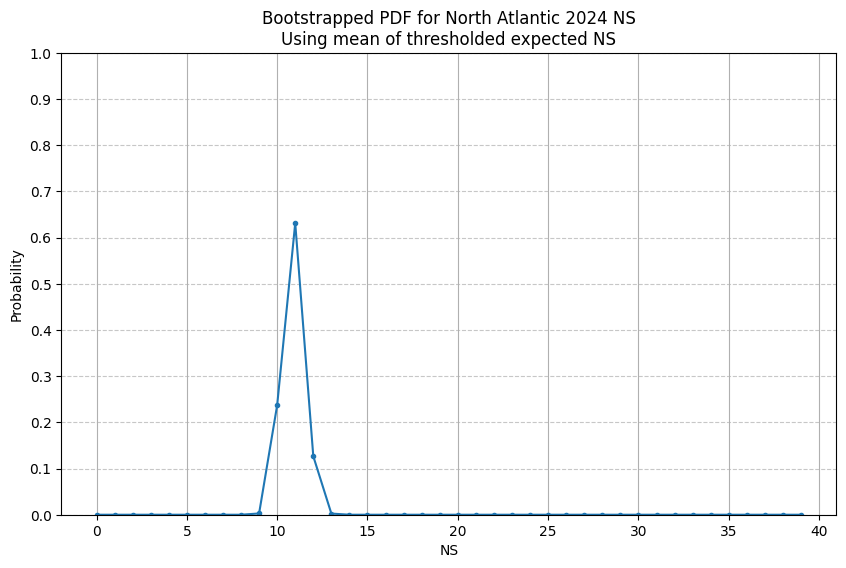

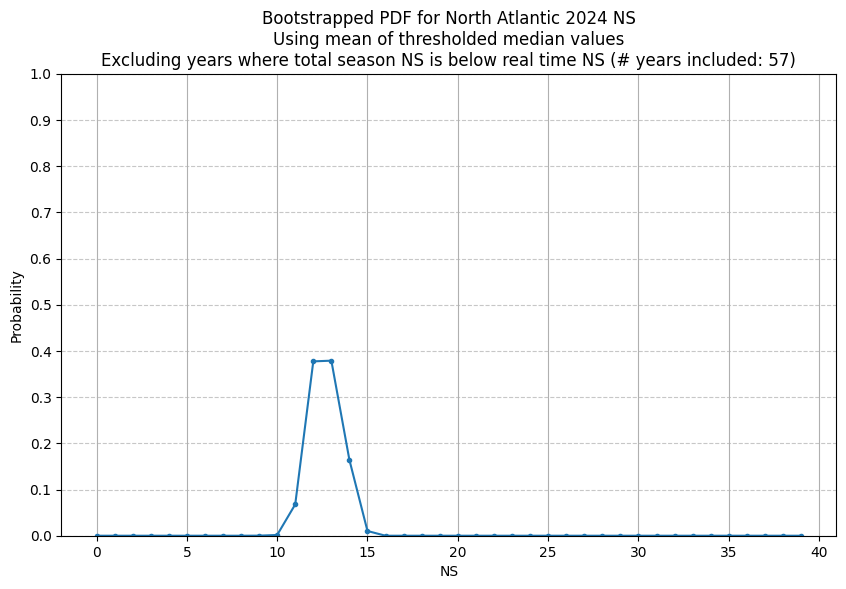


Statistics for 1966 - 2023 excluding years with season NS < real time NS:
μ: 13.04
median: 13.00

Range using RMSE (without validation RMSE): 6.8382601228084345 : 14.880132619710302
Range using RMSE (with validation RMSE):    6.8094662867210465 : 14.90892645579769


In [246]:
# Specify the confidence level (e.g., 90% CI)
confidence_level = 0.7





# use bootstrapping instead for CI

# Number of bootstrap samples to generate
num_samples = 100000

# Calculate the statistic of interest (e.g., mean) for the original data
original_statistic = expected_NS

# Initialize an array to store resampled statistics
resampled_statistics = np.empty(num_samples)

# Range of values for PDF estimation
#values_of_interest = list(range(round(real_time_NS), round(max(pop_NS_values)), 1))
#values_of_interest = list(range(round(real_time_NS), round(50), 1))
values_of_interest = list(range(0, 40, 1))

# store when the median is greater than each value of interest
binary_outcomes = np.empty((num_samples, len(values_of_interest)))

# Perform bootstrapping
for i in range(num_samples):
    # Generate a resampled dataset by sampling with replacement
    
    # cannot do random choice on a dict...
    #resampled_data = np.random.choice(season_NS_above_real_time, size=len(season_NS_above_real_time), replace=True)
    
    num_sample_years = len(season_NS_above_real_time)  # Number of samples you want to draw
    # Randomly select keys from the dictionary with replacement
    random_keys = random.choices(list(season_NS_to_time_end.keys()), k=num_sample_years)
    # Use the selected keys to access corresponding values
    random_values = [season_NS_to_time_end[key] for key in random_keys]
    
    # since I need to pass a dict that should have multiple keys repeated, do something extra to keep track of the 'repeats'
    repeat_counts = dict(Counter(random_keys))
    
    resampled_data = {key: value for key, value in zip(random_keys, random_values)}
    
    # Calculate the statistic of interest for the resampled dataset
    [resampled_statistic, weights_normalized_by_year] = calculate_expected_NS(resampled_data, repeat_counts)
    
    # Store the resampled statistic
    resampled_statistics[i] = resampled_statistic
    
    binary_outcome = []
    for value in values_of_interest:
        if round(resampled_statistic) == value:
            binary_outcome.append(1)
        else:
            binary_outcome.append(0)
    binary_outcomes[i] = binary_outcome
    
# Calculate the PDF for each value of interest (using the average of the thresholded binary outcomes)
pdf1 = np.mean(binary_outcomes, axis=0)

print("")

# Plot the PDF
plt.figure(figsize=(10, 6))
plt.plot(values_of_interest, pdf1, marker='.', linestyle='-')
plt.xlabel('NS')
plt.ylabel('Probability')
plt.title('Bootstrapped PDF for North Atlantic 2024 NS\nUsing mean of thresholded expected NS')

# Set y-axis limits to 0.0 and 1.0
plt.ylim(0.0, 1.0)

# Customize y-axis ticks and grid lines at intervals of 0.1
plt.yticks(np.arange(0, 1.1, 0.1))
plt.gca().yaxis.grid(True, linestyle='--', alpha=0.7)
plt.grid(True)
plt.show()






# Calculate the lower and upper bounds of the confidence interval
alpha = 1 - confidence_level
lower_bound = np.percentile(resampled_statistics, 100 * alpha / 2)
upper_bound = np.percentile(resampled_statistics, 100 * (1 - alpha / 2))

# Print the results
#print(f"(bootstrapped) CI using expected value ({confidence_level*100:2.1f}%): [{lower_bound:3.2f}, {upper_bound:3.2f}]")

# use bootstrapping instead for CI

# Number of bootstrap samples to generate
num_samples = 100000

# Calculate the statistic of interest (e.g., mean) for the original data
original_statistic = NS_median

# Initialize an array to store resampled statistics
resampled_statistics = np.empty(num_samples)

# Range of values for PDF estimation
values_of_interest = list(range(0, 40, 1))

# Initialize an array to store PDF from bootstraps
binary_outcomes = np.empty((num_samples, len(values_of_interest)))

# Perform bootstrapping
for i in range(num_samples):
    # Generate a resampled dataset by sampling with replacement
    resampled_data = np.random.choice(pop_NS_values, size=len(pop_NS_values), replace=True)
    
    # Calculate the statistic of interest for the resampled dataset
    resampled_statistic = np.median(resampled_data)
    
    # Store the resampled statistic
    resampled_statistics[i] = resampled_statistic

    # Threshold on the values of interest using the expected NS
    binary_outcome = []
    for value in values_of_interest:
        if round(resampled_statistic) == value:
            binary_outcome.append(1)
        else:
            binary_outcome.append(0)
    binary_outcomes[i] = binary_outcome
    
# Calculate the PDF for each value of interest (using the average of the thresholded binary outcomes)
pdf2 = np.mean(binary_outcomes, axis=0)
print("")


# Plot the PDF
plt.figure(figsize=(10, 6))
plt.plot(values_of_interest, pdf2, marker='.', linestyle='-')

plt.xlabel('NS')
plt.ylabel('Probability')
plt.title(f'Bootstrapped PDF for North Atlantic 2024 NS\nUsing mean of thresholded median values\nExcluding years where total season NS is below real time NS (# years included: {n_pop_NS_values})')

# Set y-axis limits to 0.0 and 1.0
plt.ylim(0.0, 1.0)

# Customize y-axis ticks and grid lines at intervals of 0.1
plt.yticks(np.arange(0, 1.1, 0.1))
plt.gca().yaxis.grid(True, linestyle='--', alpha=0.7)

plt.grid(True)
plt.show()
    
# not useful with long tail
# Specify the confidence level (e.g., 90% CI)
confidence_level = 0.54

# Calculate the lower and upper bounds of the confidence interval
alpha = 1 - confidence_level
lower_bound = np.percentile(resampled_statistics, 100 * alpha / 2)
upper_bound = np.percentile(resampled_statistics, 100 * (1 - alpha / 2))


print("")
print(f"Statistics for {sorted_years[0]} - {sorted_years[-1]} excluding years with season NS < real time NS:")
print(f"μ: {NS_mean:3.2f}")
print(f"median: {NS_median:3.2f}")

# not as useful since it doesn't handle constraints well so don't use general statistics below for CI:
#print("σ:", NS_stddev)
#print("Z score for expected NS:", z_score)
#ci_lower = expected_NS - (critical_value * NS_stddev)
#ci_upper = expected_NS + (critical_value * NS_stddev)
#print(f"CI({confidence_level}) = [ {ci_lower} , {ci_upper} ]")


# expect the tuned decay rate should automatically increase as the season passes
#   this means, later in the season it will be more selective in using years that have NS that are very close to the present
#   as opposed to early in the season when the years will be more of an average
# for instance on Sept 24 06Z it was 0.147, and on Sept 25 00Z it was 0.171
print("")

# diagnostics for model predictiveness as the season progresses
expected_NS_upper = expected_NS + rmse_final_tuning
expected_NS_lower = expected_NS - rmse_final_tuning
print(f"Range using RMSE (without validation RMSE): {expected_NS_lower} : {expected_NS_upper}")
expected_NS_upper_with_validation = expected_NS + rmse_final_tuning + diff_rmse
expected_NS_lower_with_validation = expected_NS - rmse_final_tuning - diff_rmse
print(f"Range using RMSE (with validation RMSE):    {expected_NS_lower_with_validation} : {expected_NS_upper_with_validation}")

In [247]:
# weight two predictors by sample size
# first predictor must account for unequal weights (inflating the sample size)
# consider for reference where all weights are given equal value (1/n)
#    then, for a weight that is less than or equal to 1/10 of (1/n),
#    let us consider such a weight as not contributing enough and is inflating the sample size
num_total_weights = len(sorted_weights_by_year)
contributing_threshold = (1/10) * (1/num_total_weights)
num_contributing_weights = 0
for rank, (year, weight) in enumerate(sorted_weights_by_year.items(), start=1):
    if weight > contributing_threshold:
        num_contributing_weights += 1
        
n1 = num_contributing_weights
n2 = n_pop_NS_values
w1 = n1 / (n1 + n2)
w2 = n2 / (n1 + n2)

print(n1, n2)
weighted_pdf = []
#p_weighted = prob_exp*w1 + prob_realtime*w2
orig_pdfs = []
orig_bins = []
for i, (p_exp, prob_realtime) in enumerate(list(zip(pdf1, pdf2))):
    p = prob_exp*w1 + prob_realtime*w2
    weighted_pdf.append((i, p))
    
cum = 0
for i, pdf in weighted_pdf:
    cum += pdf

norm_weighted_pdf = []
for (i, p) in weighted_pdf:
    norm_weighted_pdf.append((i, p / cum))
    orig_bins.append(i)
    orig_pdfs.append(p / cum)

print(norm_weighted_pdf)
# print(f"(NS=160) Weighting the two predictors: (weighting Exp: {w1:.1f}, Realtime: {w2:.1f}): {p_weighted*100:.2f}%")

10 57
[(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.00016), (10, 0.00159), (11, 0.06778), (12, 0.37737), (13, 0.37892), (14, 0.16399), (15, 0.01019), (16, 0.0), (17, 0.0), (18, 0.0), (19, 0.0), (20, 0.0), (21, 0.0), (22, 0.0), (23, 0.0), (24, 0.0), (25, 0.0), (26, 0.0), (27, 0.0), (28, 0.0), (29, 0.0), (30, 0.0), (31, 0.0), (32, 0.0), (33, 0.0), (34, 0.0), (35, 0.0), (36, 0.0), (37, 0.0), (38, 0.0), (39, 0.0)]


In [214]:
with open('season_NS.csv', 'w') as file:
    for [year,NS] in season_NS.items():
        file.write(f"{year}, {NS}\n")

In [248]:
#binning example
number_of_existing_named_storms = 5
# Sept 7 - Nov 30, 2024 PDF for NATL Named storms
orig_pdfs = np.array(orig_pdfs)

orig_bins = np.array(orig_bins)
dest_bins = [(0,10), (11,15), (16,20), (21,25), (26,30), (31, 35), (36, 999)]
orig_pdf_in_bins = list(zip(orig_bins, orig_pdfs))
dest_pdf_in_bins = {}
for orig_bin, orig_pdf in orig_pdf_in_bins:
    for dest_bin in dest_bins:
        bin_min = dest_bin[0]
        bin_max = dest_bin[1]
        if orig_bin >= bin_min and orig_bin <= bin_max:
            if dest_bin not in dest_pdf_in_bins:
                dest_pdf_in_bins[dest_bin] = np.float64(0.0)
            dest_pdf_in_bins[dest_bin] += orig_pdf

print(dest_pdf_in_bins)

{(0, 10): 0.00175, (11, 15): 0.99825, (16, 20): 0.0, (21, 25): 0.0, (26, 30): 0.0, (31, 35): 0.0, (36, 999): 0.0}
